# Predicting Poltical Orientation from Twitter Data
### Cognitive, Behavioural and Social Data

Outline of the report:
>Introduction
<br>
>Presentation of the dataset
<br>
>Presentation of data analysis methodology
<br>
>Results and conclusion

## 1 INTRODUCTION

### 1.1 Abstract

<br>

<div style="text-align: justify"> 
In recent years, analyzing data acquired from social networks platform to predict and understand more about human cognition, behaviors and orientation has been a rising trend. Social media has changed not only the way we passively receive information but also how we express our personal opinions about everyday issues. That is the reason why Facebook, Twitter, Youtube and other social networks have become valuable sources of data that can be beneficial for many areas. Automatic political orientation prediction from social media posts has been proven successful in distinguishing between liberals and conservatives in the US. In this project, we will try to do political orientation prediction on Italian language and Italian political landscape.
<br>
    
As mentioned previously, there are many social media platforms that can be taken benefits from. But in this small project, we use Twitter instead of Facebook and Instagram, since they have special restricted community policies that do not allow some contents to be public. Also, Twitter has an API and allows developer account to access and download data from it.
<br>
    
The aim is to investigate whether it is possible to predict users’ political orientation from Twitter data. More precisely, we had the task of predicting the political orientation of an Italian Twitter account chosen at random, using different machine learning models. 
</div>

### 1.2 Aim of the analysis
<br>

<div style="text-align: justify"> 
The project consists of two main phases:
<br>
    
1. We begin by crawling random Italian Twitter accounts (total 1000) and start labeling their favorite political parties (Lega, Partito Democratico, Fratelli d’Italia, Movimento 5 Stelle and Forza Italia) by going through their accounts. We do this 5 different times by 5 different group members, then calculating the marked party frequency for each account.
2. In the second phase, we crawl all the tweets associated with those accounts. Data of classified Twitter accounts and tweet contents from different groups will be combined into one big dataset. Then we fix a threshold for political party labeling on each account then merge the newly downloaded data with the labeled account data from phase 1. The purpose of this phase is to train and test different classification models on the tweet contents to predict the political orientation “right vs left”. Lega, Fratelli d’Italia, and Forza Italia are considered as right wing while Partito Democratico is left wing. After training and testing the classification models, we will use them on the labeled data of Movimento 5 Stelle to see how they classify these accounts to “right” or “left”, since this party is controversial and difficult to classify left or right even for humans.
<br>

In the analysis and classification phase, we follow the following agenda:
* Doing an initial exploratory data analysis (EDA) to have an overview of the dataset
* Fixing a threshold to set the “final” orientation of each user. Merging labeled account data and tweets data and doing preprocessing on the merged data.
* Removing stop words and vectorizing tweets. Applying some classification models such as Random Forest, SGD Classifier, Naive Bayes, Xgboost, etc. Then using some techniques such as grid search and and some metrics such as accuracy score, confusion matrix and classification report of sklearn library to choose the optimal models and tuned parameters.
* Applying the model to M5S data to see the results. However, the data of M5S party is probably biased and unusable since there is one group who labeled around 80% of their users as M5S and the remaining 20% as Partito Democratico.
</div>

### 1.3 Initial Statistics
<br>
Before delving into the huge dataset that was generated from all of the groups, we decided to do some initial statistics analysis on the dataset that our group gathered. As shown in the code snippets bellow we gained insights on user twitter activity, user vocabulary and time period usage analysis.
<br>

In [1]:
import pandas as pd

types = {
    'created_at': 'str', 
    'id': 'str',
    'favorites': 'int32',
    'retweets': 'int32',
    'source': 'str',
    'full_text': 'str',
    'username': 'str'
}

combined = pd.read_csv('../group_tweets.csv', parse_dates=True, index_col='created_at', dtype=types)
combined.head()

,id,favorites,retweets,source,full_text,username
created_at,,,,,,
2019-10-11 05:02:41,1182521882895106049,0,846,Twitter for Android,RT @PaoloGentiloni: I #curdi siriani hanno com...,nicolalicci1
2019-10-11 04:58:31,1182520831643209728,0,557,Twitter for Android,RT @nzingaretti: L’azione militare unilaterale...,nicolalicci1
2019-10-11 04:56:43,1182520380717780992,0,0,Twitter for Android,"@PierMaran Mah, è sempre stato un obiettivo de...",nicolalicci1
2019-10-11 04:46:17,1182517755783897088,0,247,Twitter for Android,"RT @LaNotiziaTweet: La #Raggi aveva ragione, c...",nicolalicci1
2019-10-10 12:20:30,1182269672139493382,0,0,Twitter for Android,@virginiaraggi @matteosalvinimi Chi si lamenta...,nicolalicci1


We started by doing some initial exploration, starting with number of tweets per day.
Even with the first plot there seems to be an interesting pattern. Jumps at 2014, 2015 can be attributed most likely to New Year Tweets

In [2]:
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
%matplotlib inline

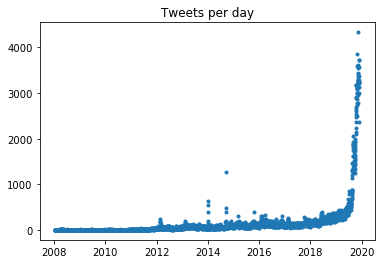

In [3]:
fig, ax = plt.subplots()
ax.plot(combined.resample('D').count().loc[:, 'id'], marker='.', linestyle='None', label='Daily Number of tweets')

plt.title('Tweets per day')
plt.savefig('daily_tweets.jpg')

Further Inspection is needed to see the pattern emerging in the second part of 2019

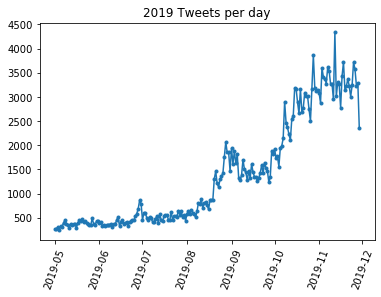

In [4]:
explore_2019 = combined.loc['2019-05-1':, :]

fig, ax = plt.subplots()
plt.xticks(rotation=70)
ax.plot(explore_2019.resample('D').count().loc[:, 'id'], marker='.', linestyle='-')

plt.title('2019 Tweets per day')
plt.savefig('daily_tweets_range.jpg')

The plot clearly shows an almost exponential growth of number of tweets starting somewhere in the middle of August. A hypothesis can be stated that this increase might be caused by the political crisis occurcing in Italy during this period, given that twitter is known for beeing a place to express political opinion with a safe, anonymous profile.
<br><br>
In the following plots, we explored the length of the time periods in which the users were active on the site. More concretely, we computed the time difference between the first and last post of each user to determine what is the average time that a user is active on the site

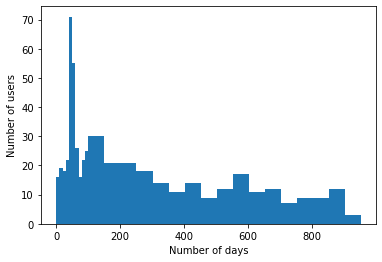

In [9]:
import numpy as np

def get_days_active(row):
    time = row['first'] - row['last']
    return time.days

user_activity = combined.reset_index().groupby('username')['created_at'].agg(['last', 'first'])
user_activity['days_active'] = user_activity.apply(get_days_active, axis=1)

ax = user_activity['days_active'].plot(kind='hist', x='Number of days', y='Number of users', 
                                  bins=list(np.concatenate((np.arange(0,101,10), np.arange(101, 1001, 50))))
                                 )
ax.set_xlabel('Number of days')
ax.set_ylabel('Number of users')

#plt.subplots()
#ax = user_activity['days_active'].plot(kind='hist',
                                 # bins=list(np.arange(500,5000,100))
                                 #)
#ax.set_xlabel('Number of days')
#ax.set_ylabel('Number of users')
#None

plt.savefig('activity.jpg')

As a last step before we started working on the entire dataset, we investigated the textual aspect of our data and tried to find interesting details within it.

In [21]:
lens = [len(x.split(' ')) for x in combined['full_text']]
corpus = {word: 0 for sentence in combined['full_text'] for word in sentence.lower().split(' ')}

print(f'Number of words used: {sum(lens)}\nNumber of unique words: {len(corpus)}')

Number of words used: 8984154
Number of unique words: 1024309


In [22]:
for tweet in combined['full_text']:
    for word in tweet.lower().split(' '):
        corpus[word]+=1

In [24]:
most_used_words = [word for (word, count) in corpus.items() if count>5000]
most_used_words[25:35]

['gli',
 'con',
 'delle',
 'non',
 '@matteosalvinimi',
 'chi',
 'si',
 'anni',
 'ci',
 'sono']

And this is a wonderfull result to get before delving deeper into the data analysis and modeling. As we observed in the previous cell, @matteosalvinimi is the 30th most used "word" in our dataset. Given the fact that we have a task to determine political affiliation from these tweets this is a motivating observation.

## 2 DATA COLLECTION AND PREPARATION

<div style="text-align: justify"> 
    
As already mentioned, our aim is to predict the political orientation of an Italian Twitter account chosen at random, using different machine learning models. For collecting the data, we used “Tweepy” – a Python library for accessing the Twitter API. This way, we were able to get 8000+ Italian Twitter Accounts, as well as their tweets.
<br>

Political orientation was defined as a categorical variable where each category (numbers from 1-5) corresponds to a political party: Lega (@LegaSalvini) – 1, Partito Democratico (@pdnetwork) – 2, Fratelli d’Italia (@Fratelliditalia) – 3, Movimento 5 Stelle (@Mov5Stelle) – 4 and Forza Italia (@forza_italia) – 5. 
<br>

Random Italian Twitter accounts were gathered and their sex, political orientation according to the categorical variables defined earlier, and other information found relevant were labeled. This was done by going through the user’s account and reading their tweets. After reading enough tweets, all members decided on the sex of the user, while each one separately labeled the user. Subsequently, we calculated and marked the political party preference frequency for each account. From the data collected, we were able to see that 4 accounts had already been either deleted or suspended. 588 of the users were male (noted with “M” in the sex column of the dataset), 228 were female (“F” in the sex column of the dataset) and we could not decide the gender on 170 users (“U” in the sex column of the dataset). With a 100% certainty, we identified 180 supporters of Lega, 183 of Partito Democratico, 87 of Fratelli d’Italia, 87 of Movimento 5 Stelle, and 25 of Forza Italia. We were not able to identify the political orientation of 316 users. 

</div>

<div style="text-align: justify"> 
The second phase consisted of crawling all the tweets associated with the collected Twitter accounts. Our initial data was merged with data from the other groups and combined into one big dataset that includes 7889 users, of which 2572 could not be identified with a political party. 4710 users of the dataset are male (noted with “M” in the sex column of the dataset), 2077 are female (“F” in the sex column of the dataset), while the sex of the other users is unidentified (“U” or “-“ in the sex column of the dataset). This dataset includes the frequency of votes for the political party, as well as a column explaining from which task the data is provided. 
</div>

In [30]:
data = pd.read_excel('./LabelledAccounts.xlsx')
data.head()

,Unnamed: 0,Twitter ID Information,Unnamed: 2,Unnamed: 3,Political Party Labelling,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Other Info (Notes),Unnamed: 10,Class Frequency,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,NaN,Twitter ID,User Name,Sex (M/F),SID 1,SID 2,SID 3,SID 4,SID 5,NaN,NaN,0.0,1.0,2.0,3.0,4.0,5.0,TASK
1,NaN,@marco_ssl,Marco_SSL,M,3,3,1,1,NaN,NaN,NaN,0.0,0.5,0.0,0.5,0.0,0.0,T2P3
2,NaN,@Mutaz53214,Mutaz,M,3,3,3,3,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,T2P3
3,NaN,@predieridanilo,predieri danilo,M,2,4,2,4,NaN,NaN,NaN,0.0,0.0,0.5,0.0,0.5,0.0,T2P3
4,NaN,@Loredan83532601,Loredana,F,1,1,3,3,NaN,NaN,NaN,0.0,0.5,0.0,0.5,0.0,0.0,T2P3


<div style="text-align: justify">
After merging, the data was cleaned and formatted for building the Machine Learning models. We began by re-formatting the excel classification file for and dropping empty columns for ease of use. The data is now organized in 14 columns: id (set as the index of the dataset); sex (labeled with “M”, “F”, or “U” / "-"); sid_1, sid_2, sid_3, sid_4, sid_5 which correspond to the opinion of the ith  group member about a specific user j in (1, 2, 3, 4, 5); cls_0, cls_1, cls_2, cls_3, cls_4, cls_5 which correspond to the frequency of votes for the political party (Lega, Partito Democratico, Fratelli d’Italia, Movimento 5 Stelle and Forza Italia, respectively); and task – to keep track of where the data came from. 
</div>


In [31]:
data.drop(0, inplace=True)
data.pop('Unnamed: 0')
data.pop('Unnamed: 2')
data.pop('Other Info (Notes)')
data.pop('Unnamed: 10')

cols = ['id', 'sex', 'sid_1', 'sid_2', 'sid_3', 'sid_4', 'sid_5', 
        'cls_0', 'cls_1', 'cls_2', 'cls_3', 'cls_4', 'cls_5', 'task']
data.columns = cols

data['sid_5'].fillna(0, inplace=True)
data.set_index('id', inplace=True)

data.head()

,sex,sid_1,sid_2,sid_3,sid_4,sid_5,cls_0,cls_1,cls_2,cls_3,cls_4,cls_5,task
id,,,,,,,,,,,,,
@marco_ssl,M,3,3,1,1,0,0.0,0.5,0.0,0.5,0.0,0.0,T2P3
@Mutaz53214,M,3,3,3,3,0,0.0,0.0,0.0,1.0,0.0,0.0,T2P3
@predieridanilo,M,2,4,2,4,0,0.0,0.0,0.5,0.0,0.5,0.0,T2P3
@Loredan83532601,F,1,1,3,3,0,0.0,0.5,0.0,0.5,0.0,0.0,T2P3
@FbCataldo,M,1,1,1,1,0,0.0,1.0,0.0,0.0,0.0,0.0,T2P3


<div style="text-align: justify">
Before dividing the data into a binary dataset, we had to check whether the data was error-free. After making a check for cls_1 (frequency of votes that correspond to Lega), we were able to see that there is inconsistency in the dataset, where it is unclear whether the cls columns count or give the frequency of the votes. We additionally found out that there are 963 faulty rows which do not conform to the frequency criterion (that needs to sum up to 1). Since our group built a model on a smaller sample of the data, we dropped these rows from further consideration. However, if needed, these rows can be recovered by calculating the cls columns manually from the sid_i columns (i ranging from 1-5).
</div>

In [32]:
data['cls_1'].value_counts()

0.00    5827
1.00     935
0.80     370
0.60     169
0.50     156
4.00     102
0.20      96
0.40      70
0.25      62
0.75      58
3.00      24
2.00      20
Name: cls_1, dtype: int64

<div style="text-align: justify">
Another check that was performed is the validity of rows, which gave us a total of 6926 users to work with:
</div>

In [33]:
def is_row_valid(row):
    return sum(row[
        [f'cls_{i}' for i in range(0, 6)]
    ]) == 1

mask = data.apply(is_row_valid, axis=1)
print(f'Users before cleaning: {len(data)}')
data = data[mask]
print(f'Users after cleaning:{len(data)}')

Users before cleaning: 7889
Users after cleaning:6926


<div style="text-align: justify">
Looking at the following table ensures us that we have more than 1000 users for each political orientation even by setting the threshold value as 1 which we will do to reduce bias:
</div>

In [34]:
data[[f'cls_{i}' for i in range(0, 6)]].apply(pd.Series.value_counts)

,cls_0,cls_1,cls_2,cls_3,cls_4,cls_5
0.00,4217.0,5450,5540,5203,6491,6608
0.20,79.0,74,62,49,71,186
0.25,2.0,62,3,64,1,10
0.40,32.0,58,74,98,74,18
0.50,NaN,156,6,155,4,4
0.60,34.0,104,84,42,47,14
0.75,NaN,58,1,61,1,3
0.80,10.0,49,47,183,15,5
1.00,2552.0,915,1109,1071,222,78


<div style="text-align: justify">
After data was cleaned and a threshold of 0.95 was set, we could see that we were working with 915 supporters of Lega, 1109 of Partito Democratico, 1071 of Fratelli d’Italia, 222 of Movimento 5 Stelle, and 78 of Forza Italia, unanimously voted as members of the corresponding political party:
</div>

In [35]:
thresh = 0.95

lega_prospects = data[data['cls_1'] > thresh].reset_index()['id']
pade_prospects = data[data['cls_2'] > thresh].reset_index()['id']
frat_prospects = data[data['cls_3'] > thresh].reset_index()['id']
msta_prospects = data[data['cls_4'] > thresh].reset_index()['id']
forz_prospects = data[data['cls_5'] > thresh].reset_index()['id']

prospects_list = [lega_prospects, pade_prospects, frat_prospects, msta_prospects, forz_prospects]
print(f'LEGA supporters: {len(lega_prospects)}')
print(f'PD supporters: {len(pade_prospects)}')
print(f'FDI supporters: {len(frat_prospects)}')
print(f'M5S supporters: {len(msta_prospects)}')
print(f'FI supporters: {len(forz_prospects)}')

LEGA supporters: 915
PD supporters: 1109
FDI supporters: 1071
M5S supporters: 222
FI supporters: 78


<div style="text-align: justify">
Checking whether we have the necessary tweets of the corresponding users, we realized that some of them are missing and that we are dealing with a kind of name discrepancy since more than half of the users and files do not match. The dataset is now filled with 2795 users, 693 of which are supporters of Lega, 1076 of Partito Democratico, 741 of Fratelli d’Italia, 213 of Movimento 5 Stelle, and 72 of Forza Italia:
</div>

In [16]:
from os import listdir

files = [re.sub('_tweets.csv', '', file) for file in listdir('./data/tweets/')]
[sum([True if user in files else False for user in prospects]) for prospects in prospects_list]

[693, 1076, 741, 213, 72]

<div style="text-align: justify">
For the binary classification, we take all 1076 Twitter accounts supporting Partito Democratico marked as left-wing, and a combination of 1076 right-wing affiliates from the Twitter accounts supporting Lega, Fratelli d’Italia and Forza Italia. Of course, cleaning the tweets was necessary. We decided to keep hashtags and mentions because as we saw in the initial statistics part, @matteosalvini was widely used and we thought it will help our models to better classify the users.
</div>

In [17]:
def get_and_clean_tweets(user):
    df = pd.read_csv(f'./data/tweets/{user}_tweets.csv', header=0)
    content = ' '.join(df['full_text'])
    content, _ = re.subn(r'\r', '', content)
    content, _ = re.subn(r'\n', '', content)
    content, _ = re.subn(r'RT', '', content)
    content, _ = re.subn(r'http.*?(?=\s)', '', content)
    content, _ = re.subn(r'…', '', content)
    return content

In [18]:
#To automate this process further wrap the upper in a more general function:
def get_df(users, party, count):
    
    rows = []
    counter, i = 0, 0    
    
    while counter<count :
        user = users[i]
        if user in files:
            counter+=1
            df = rows.append([user, party, get_and_clean_tweets(user)])
        i+=1
    return rows

In [19]:
lega_tweets = get_df(lega_prospects, 1, 502)
pade_tweets = get_df(pade_prospects, 2, 1075)
frat_tweets = get_df(frat_prospects, 3, 502)
msta_tweets = get_df(msta_prospects, 4, 212)
forz_tweets = get_df(forz_prospects, 5, 71)

In [20]:
df_lega = pd.DataFrame(lega_tweets)
df_pade = pd.DataFrame(pade_tweets)
df_frat = pd.DataFrame(frat_tweets)
df_msta = pd.DataFrame(msta_tweets)
df_forz = pd.DataFrame(forz_tweets)

In [21]:
clean_data = pd.concat([df_lega, df_pade, df_frat, df_forz])
clean_data.head()

,0,1,2
0,@Nicolgentilcor4,1,@Giorgiolaporta: Lancio una proposta: se crea...
1,@APunginelli,1,@CieloItalia @gisellebardot Applaudiamo al gra...
2,@SSestesso,1,@GiorgiaMeloni Nuova #LONDONFALSFLAG Forse @Ce...
3,@Paolo91296530,1,@Annaelegalita ciao @Giadaforevah Brava @SaraA...
4,@BerselliThomas,1,@FrDelPapa @AndreaScanzi @Azione_it Datti una ...


<div style="text-align: justify">
Finally, we assign right-left label to each tweet using the following mapping: Left/0 if it is left-wing (taking 1076 Partito Democratico supporters) and Right/1 if it falls under the right-wing affiliates mentioned above (1076 right-wing affiliates). We export this .cvs file.
</div>

In [22]:
cols = ['id', 'party', 'tweets']
clean_data.columns=cols
clean_data.set_index('id', inplace=True)
clean_data['direction'] = clean_data['party'].map({2:0, 1:1, 3:1, 5:1})
clean_data.head()

,party,tweets,direction
id,,,
@Nicolgentilcor4,1,@Giorgiolaporta: Lancio una proposta: se crea...,1
@APunginelli,1,@CieloItalia @gisellebardot Applaudiamo al gra...,1
@SSestesso,1,@GiorgiaMeloni Nuova #LONDONFALSFLAG Forse @Ce...,1
@Paolo91296530,1,@Annaelegalita ciao @Giadaforevah Brava @SaraA...,1
@BerselliThomas,1,@FrDelPapa @AndreaScanzi @Azione_it Datti una ...,1


This file will be the main one used for training the models.

In [23]:
clean_data.to_csv('./binary_tweets.csv', index='id')

<div style="text-align: justify">
To avoid any future problems, the group took tweets of Movimento 5 Stelle into a separate .csv file.
</div>

In [24]:
df_msta = pd.DataFrame(msta_tweets)
cols = ['id', 'party', 'tweets']
df_msta.columns = cols
df_msta.set_index('id', inplace=True)
df_msta.head()

,party,tweets
id,,
0Cieri,4,@OmnibusLa7 se al mio ex fosse stato chiesto u...
rosalbadeangeli,4,Siamo messi veramente male per chi ha i paraoc...
bezzoneclaudio,4,@Marcoclari1: Se nn si fosse capito che è una...
LobinaLuciano,4,Open Money da Firenze il raccattatore di euro ...
Viviaristo1,4,@_CircoMassimo_ @NicolaGratteri grande. Parole...


In [25]:
df_msta.to_csv('./msta_tweets.csv', index='id')

## 3 MODEL BUILDING

<div style="text-align: justify">
Once the data was nicely formatted, some models were built according to it. Data from users labeled by the majority as Lega, PD, FDI and FI is used to train models that predict the political orientation behind a tweet. The M5Star users were splitted into another file and not used to train the models. After building the models, at the end M5S supporters were classified by it to see whether they fell into one of the two categories.
</div>

In [38]:
data = pd.read_csv('./binary_tweets.csv', index_col='id')
data.head()

,party,tweets,direction
id,,,
@Nicolgentilcor4,1,@Giorgiolaporta: Lancio una proposta: se crea...,1
@APunginelli,1,@CieloItalia @gisellebardot Applaudiamo al gra...,1
@SSestesso,1,@GiorgiaMeloni Nuova #LONDONFALSFLAG Forse @Ce...,1
@Paolo91296530,1,@Annaelegalita ciao @Giadaforevah Brava @SaraA...,1
@BerselliThomas,1,@FrDelPapa @AndreaScanzi @Azione_it Datti una ...,1


<div style="text-align: justify">
Firstly, the users' tweets were defined as X and the user binary label direction as y. Before starting to try different models and finetuning the best, the data was split in training and test sets. We found out that a proportion of 80%-20% works fine.
</div>

In [80]:
from sklearn.model_selection import train_test_split

X = data['tweets']
y = data['direction']

X_train , X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y)

### 3.1 Model selection

<br>

<div style="text-align: justify"> 
We begin with a model among the multitude to see which one is the most convenient for our purpose. We take into account scores as accuracy, precision and recall but also computational simplicity, in order to make the part of fine tuning easier.
</div>

#### Establishing a baseline with a Random Forest Classifier
<br>
<div style="text-align: justify">
Since the tweets are properly cleaned, we expected that RandomForestClassifier would set a decent baseline for more complex models to outperform. Thus, we built a model with reasonable parameters in order to make comparisons with other models. To preserve initial data we built a pipeline, step-by-step, without transforming it and finally estimated the entire pipeline's performance. The step-by-step procedure is as follows:
<br>
    
1. Data needed to be transformed in numeric vectors. For this purpose TfidfVectorizer was used, which counts word occurrences among all the tweets and normalizes tweet frequencies using overall frequencies. In this way, it reduces the weight of words with no sentiment relevance, such as articles.
2. Statistically relevant features were chosen using  χ2  distribution as a score function.
3. A RandomForest Classifier with arbitary parameters was initialized.
4. A pipeline was built, and the model fitted.
</div>

In [51]:
#1
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_df=0.95)

#2
from sklearn.feature_selection import chi2, SelectKBest
selector = SelectKBest(chi2, k=600)

#3
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300)

#4
from sklearn.pipeline import make_pipeline
rf_model = make_pipeline(tfidf, selector, clf)
rf_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('tfidfvectorizer',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.95, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words=None, strip_accents=None,
                                 sublinear_tf=False,
                                 toke...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None

<div style="text-align: justify">
To evaluate the model, an accuracy score was used, since the dataset was equally splitted in left and right wing tweets. Additionally, we checked the confusion matrix and classification report to see in detail where the classification is more problematic. ??????? To compute these scores, we needed to predict the test set labels via the model.
</div>

In [52]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_predicted = rf_model.predict(X_test)
y_probas = rf_model.predict_proba(X_test)

print('Accuracy: ', accuracy_score(y_test, y_predicted))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predicted))
print('Classification report:\n', classification_report(y_test, y_predicted))

Accuracy:  0.8767441860465116
Confusion Matrix:
 [[198  17]
 [ 36 179]]
Classification report:
               precision    recall  f1-score   support

           0       0.85      0.92      0.88       215
           1       0.91      0.83      0.87       215

    accuracy                           0.88       430
   macro avg       0.88      0.88      0.88       430
weighted avg       0.88      0.88      0.88       430



A ROC curve, to visually represents the accuracy:

ROC AUC=0.953


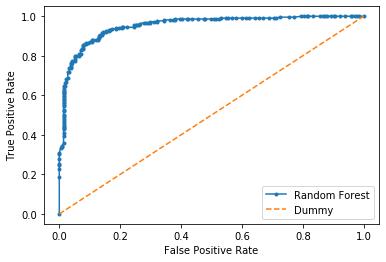

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score

y_probas_right = y_probas[:, 1]
y_probas_dummy = [0 for _ in range(len(y_probas))]

right_auc = roc_auc_score(y_test, y_probas_right)
dummy_auc = roc_auc_score(y_test, y_probas_dummy)

print('ROC AUC=%.3f' % (right_auc))

right_fpr, right_tpr, _ = roc_curve(y_test, y_probas_right)
dummy_fpr, dummy_tpr, _ = roc_curve(y_test, y_probas_dummy)

plt.plot(right_fpr, right_tpr, marker='.', label='Random Forest')
plt.plot(dummy_fpr, dummy_tpr, linestyle='--', label='Dummy')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

<div style="text-align: justify">
Since the results obtained were good, it was reasonable to set the RandomForestClassifier as a baseline for discarding other models.
</div>

#### Other Classifiers
<br>
<div style="text-align: justify">
We operated the same procedure using other models:

* A single layer neural network (<b>MLPClassifier</b>), namely a stack of Perceptrons;
* A neighbors classifier (<b>KNeighborClassifier</b>) that gives labels according to the closest neighbors;
* Adaptive boosting (<b>ADABoostClassifier</b>) which is an ensamble of weak learners which results are bagged like in a Random Forest;
* A naive Bayes classifier(<b>MultinomialNB</b>), that assigns labels according to an estimated likelihood function;
* A gradient descent classifier (<b>SGDClassifier</b>), that minimizes the error function depending on the prediction and the training labels.
</div>

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

model_dict = {
      'MLPClassifier': MLPClassifier(max_iter=150),
      'AdaBoostClassifier': AdaBoostClassifier(),
      'KNeighborsClassifier': KNeighborsClassifier(),
      'MultinomialNB': MultinomialNB(),
      'SGDClassifier': SGDClassifier() 
}

In [36]:
for name, model in model_dict.items() :
  pipe = make_pipeline(tfidf, chi2, model)
  pipe.fit(X_train, y_train)
  y_predicted = pipe.predict(X_test)

  print(name)
  print('Accuracy:', accuracy_score(y_predicted, y_test))
  print('Confusion matrix:\n', confusion_matrix(y_predicted, y_test))
  print('Classification report:\n', classification_report(y_predicted, y_test))
  print('\n\n')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier
Accuracy: 0.8364312267657993
Confusion matrix:
 [[229  56]
 [ 32 221]]
Classification report:
               precision    recall  f1-score   support

           0       0.88      0.80      0.84       285
           1       0.80      0.87      0.83       253

    accuracy                           0.84       538
   macro avg       0.84      0.84      0.84       538
weighted avg       0.84      0.84      0.84       538




AdaBoostClassifier
Accuracy: 0.862453531598513
Confusion matrix:
 [[234  47]
 [ 27 230]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.83      0.86       281
           1       0.83      0.89      0.86       257

    accuracy                           0.86       538
   macro avg       0.86      0.86      0.86       538
weighted avg       0.86      0.86      0.86       538




KNeighborsClassifier
Accuracy: 0.7881040892193308
Confusion matrix:
 [[211  64]
 [ 50 213]]
Classification report:
   

<div style="text-align: justify">
All models showed poor results in comparison to the results of the RandomForestClassifier, but the models with worst performance were KneighborsClassifier and MultinomialNB. We concluded that the best one was chosen as baseline after all.
</div>

### 3.2 Fine tuning

<br>

<div style="text-align: justify"> 
After selecting the pipeline components of our model, we focused on improving their performance. This was done by removing stopwords and searching for the hyperparameters that yield best results.
</div>

### Removing stopwords
<br>
<div style="text-align: justify">
Even though TFIDFVectorizer does a great job in giving the right importance to words, there are others that are not used as often but are not of importance to the model. These words are called stopwords and they can be removed by using a certain library - <b>nltk</b>.
</div>

In [45]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
italian_sws = set(stopwords.words('italian'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/danailkrzhalovski/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [57]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

stop_model = Pipeline([('vect', CountVectorizer(stop_words=italian_sws)),
               ('tfidf', TfidfTransformer()),
               ('chi2', SelectKBest(chi2, k=400)),
               ('clf', RandomForestClassifier(n_estimators=300))
              ])

stop_model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vect',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words={'a', 'abbia', 'abbiamo', 'abbiano',
                                             'abbiate', 'ad', 'agl', 'agli',
                                             'ai', 'al', 'all', 'alla', 'al...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,


<div style="text-align: justify">
After fitting the model using stop_words as a parameter, we checked whether the performance had improved.

In [60]:
y_predicted = stop_model.predict(X_test)

print('Accuracy: ', accuracy_score(y_test, y_predicted))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predicted))
print('Classification report:\n', classification_report(y_test, y_predicted))

Accuracy:  0.8883720930232558
Confusion Matrix:
 [[196  19]
 [ 29 186]]
Classification report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89       215
           1       0.91      0.87      0.89       215

    accuracy                           0.89       430
   macro avg       0.89      0.89      0.89       430
weighted avg       0.89      0.89      0.89       430



### Hyperparameters tuning
<br>
<div style="text-align: justify">
To find the most suitable hyperparameters, we made use of GridSearchCV which numerically maximizes the scores on a grid of values given by the coder. The parameters we tuned are the number k of best features in SelectKBest and the number n_estimators of bagged trees in RandomForestClassifier.
</div>

#### Note:
This step takes a long time to run. That is why we stored the results into a file called rf_gridsearch.txt which you can check to see the differences that the change of parameters introduces to the model.

In [ ]:
from sklearn.model_selection import GridSearchCV

pipe = make_pipeline(
    tfidf,
    SelectKBest(),
    RandomForestClassifier()
)

gs_model = GridSearchCV(
    estimator=pipe,
    param_grid={
        'selectkbest__k': [400, 600, 800, 1000],
        'randomforestclassifier__n_estimators': [100, 150, 200, 250, 300]
    },
    cv=10, n_jobs=-1, scoring='accuracy'
)

By looking at the rf_gridsearch.txt file, the best results we obtained for k=600 and n_estimators=300, with an accuracy of 91.16% and a balanced confusion matrix. Now we can instantiate the final model and afterwards perform a step called feature importance to speed it up for practical use. We will also use this model to predict M5S users.

In [99]:
cvec = CountVectorizer(stop_words=italian_sws)
cvec_vals = cvec.fit_transform(X_train)

tfidf = TfidfTransformer(use_idf=True)
tfidf_vals = tfidf.fit_transform(cvec_vals)

kbest = SelectKBest(chi2, k=600)
selected = kbest.fit_transform(tfidf_vals, y_train)

final_model = RandomForestClassifier(n_estimators=300)
final_model.fit(selected, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [100]:
cvec_vals_test = cvec.transform(X_test)
tfidf_vals_test = tfidf.transform(cvec_vals_test)

sel = kbest.transform(tfidf_vals_test)
y_predicted = final_model.predict(sel)

print('Accuracy: ', accuracy_score(y_test, y_predicted))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_predicted))
print('Classification report:\n', classification_report(y_test, y_predicted))

Accuracy:  0.9116279069767442
Confusion Matrix:
 [[198  17]
 [ 21 194]]
Classification report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91       215
           1       0.92      0.90      0.91       215

    accuracy                           0.91       430
   macro avg       0.91      0.91      0.91       430
weighted avg       0.91      0.91      0.91       430



### Feature Importance

The goal of feature selection by feature importance is to see which features had overall the biggest impact on our model and to see if by selecting those we can optimize the model to run faster in order for it to have a bigger practical impact.

To get the names of the most important features, each layer of the model needs to be processed. We can observe that the model correctly takes into account the significance of Matteo Salvini for deciding users political orientation. An interesting fact that arises is also the usage of emojis. One way to interpret the following plot is to see that different political subgroups have different vocabulary and usage of emojis to convey their thoughts.

In [123]:
importances = final_model.feature_importances_
indices = np.argsort(importances)[::-1]

mask = kbest.get_support()

cv_feats = cvec.get_feature_names()
np_cv_f = np.array(cv_feats)

most_important = np_cv_f[mask][indices[:10]]

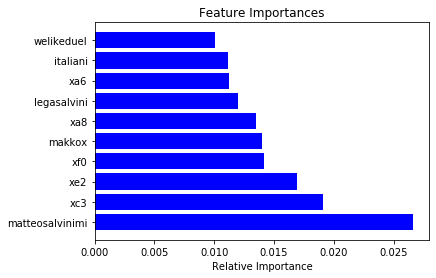

In [124]:
plt.title('Feature Importances')
plt.barh(range(len(indices[:10])), importances[indices[:10]], color='b', align='center')
plt.yticks(range(0, len(most_important)), most_important)
plt.xlabel('Relative Importance')
plt.show()

Feature Importance isn't just about seeing how our model learns the relationships between features, but also to help us further do selection of features to optimize our model in terms of speed and sometimes accuracy. 

### 3.3 M5S Classification

<br>

<div style="text-align: justify"> 
Since the M5S voters' data was very noisy, we excluded it from the training of the binary model. The model that follows is trained on the other parties' data and classifies M5S users' tweets.
</div>

In [140]:
mstar = pd.read_csv("./msta_tweets.csv", index_col='id')
mstar.head()

,party,tweets
id,,
0Cieri,4,@OmnibusLa7 se al mio ex fosse stato chiesto u...
rosalbadeangeli,4,Siamo messi veramente male per chi ha i paraoc...
bezzoneclaudio,4,@Marcoclari1: Se nn si fosse capito che è una...
LobinaLuciano,4,Open Money da Firenze il raccattatore di euro ...
Viviaristo1,4,@_CircoMassimo_ @NicolaGratteri grande. Parole...


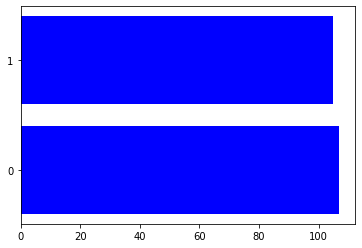

In [143]:
mstar_test = mstar['tweets']
mstar_cvec = cvec.transform(mstar_test)
mstar_tfidf = tfidf.transform(mstar_cvec)

mstar_predicted = final_model.predict(kbest.transform(mstar_tfidf))

plt.barh(range(2), [sum(mstar_predicted), len(mstar_predicted)-sum(mstar_predicted)], color='b', align='center')
plt.yticks([0, 1])
plt.show()

From this plot we can conclude that the model classifies the m5star users overall randomly giving an aproximately 50/50 split between right and left wingers. This might suggest inconsistency in the gathered data about m5star users or just non-conformity of the party itself.

## ADDITIONAL MODELS

### XGBoost

In [144]:
import xgboost as xgb

cvec_vals = cvec.transform(X_train)
tfidf_vals = tfidf.transform(cvec_vals)

kbest_xgb = SelectKBest(chi2, k=1000)
selected = kbest_xgb.fit_transform(tfidf_vals, y_train)

model = xgb.XGBClassifier(n_estimators=80, objective= 'binary:logistic', max_depth=4)
model.fit(selected, y_train)

cvec_vals_test = cvec.transform(X_test)
tfidf_vals_test = tfidf.transform(cvec_vals_test)
k_selected_test = kbest_xgb.transform(tfidf_vals_test)

predictions = model.predict(k_selected_test)
accuracy_score(y_test, predictions)

0.8813953488372093

## Determining Political Activity

Before we conclude there is a key fact that has been omitted during the building of the models. Namely our models in general, don't take into consideration the fact that a user might not be politically active and does the prediction either way.

This means that when it comes to using the model to predict arbitrary users from twitter we wouldn't expect it to perform well in general. That is why in order to cope with this problem we chose to develop a so to say, secondary model that will be trained to classify users as politicaly active or not.

To train this model, we will use the two auxilary datasets we created ("political.csv", "non-political.csv").

In [145]:
political = pd.read_csv('political.csv', index_col='id')
non_political = pd.read_csv('non_political.csv', index_col='id')

In [146]:
all_data = pd.concat([political, non_political])
all_data = all_data.sample(frac=1)
all_data.head(15)

,tweets,active
id,,
irenegiolitti,@fabfazio: Di questo parliamo quando discutia...,1
@stefanocamattin,Telese sei penoso @matteosalvinimi Stessa facc...,1
swamilee,@CarolineHirons 🤣 @Germana5761 Piccola perché ...,1
nicolettaborett,@LegaSalvini Vogliono far chiudere altre Impre...,1
mauriziobuf,Vedere nascere una nuova vita é qualcosa di me...,1
Rangel_Cruz,@larryelder: Separated at birth?#TrumpDerange...,0
vilmamoronese,"b'Buongiorno e buona domenica, se siete dalle ...",1
ivanfurlan98,@codybondarchuk: I worked at McDonald’s for t...,1
MatteoZero,@Internetfest: Come cambiano promozione e com...,0


In [147]:
(X_train_political, X_test_political,
 y_train_political, y_test_political) = train_test_split(all_data['tweets'], all_data['active'], 
                                                    stratify=all_data['active'], train_size=0.8)

print(f'X_train: {len(X_train)}\nX_test: {len(X_test)}\ny_train: {len(y_train)}\ny_test: {len(y_test)}')

X_train: 1720
X_test: 430
y_train: 1720
y_test: 430


In [149]:
cvec = CountVectorizer(stop_words=italian_sws)
cvec_vals = cvec.fit_transform(X_train_political)

tfidf = TfidfTransformer(use_idf=True)
tfidf_vals = tfidf.fit_transform(cvec_vals)

kbest = SelectKBest(chi2, k=600)
selected = kbest.fit_transform(tfidf_vals, y_train_political)

model = RandomForestClassifier(n_estimators=300)
model.fit(selected, y_train_political)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [150]:
cvec_vals_test = cvec.transform(X_test_political)
tfidf_vals_test = tfidf.transform(cvec_vals_test)
k_selected_test = kbest.transform(tfidf_vals_test)

predictions = model.predict(k_selected_test)
accuracy_score(y_test_political, predictions)

0.7466960352422908

This is a path that needs to be considered and developed more thoroughly to have a substancial effect on the previous models. In the future it might prove to be an important addition to the political affiliation prediction process.

## 4 CONCLUSION

<div style="text-align: justify">
For selecting of a model, we tried the following components of the pipeline that, for reasons of readibility, we didn't included entirely in this report. Nevertheless, it's interestining to mention the following:

1. <b>Preprocessing tools</b>
    * Count vectorizer
    * TfidfVectorizer
    * nltk stopwords library (as integration of TfidfVectorizer)
    * FastText
    
<p> 

</p>

2. <b>Feature selectors:</b>:
    * SelectKBest
    * SelectPercentile
    * SelectFromModel
    * PCA 
    
<p> 

</p>

3. <b>Classifiers</b>:
    * Random Forest
    * One-layer neural network (`MLPClassifier`)
    * Neighbors classifier (`KNeighborClassifier`)
    * Adaptive Boosting (`ADABoostClassifier`)
    * Naive Bayes classifier (`MultinomialNB`)
    * Gradient Descent classifiers (`SGDClassifier` and Light Gradient Boosting Machine)
    * XGBoost

</div>

<div style="text-align: justify">
The results were generated, as previously stated, splitting the labelled users into a training set of 80% and a testing set of 20%. Between all models, the most successful one was the Random Forest Classifier, providing an accuracy of 91.16% with some fine tuning (removing stopwords, grid search on hyperparameters). The other good one has been the XGBoost, with an accuracy of ___. These are the overall results:
</div>

|Model         | Accuracy | 
| :----------- | -------: | 
|RandomForest  | 0.9116| |
|ADABoost      | 0.8623| |
|MLPClassifier | 0.8364| |
|MultinomialNB | 0.7806| |
|XGBoost       | 0.8813| |
|SGDClassifier | 0.8215| |

</div>

<div style="text-align: justify">
One thing that doesn't emerge from the previous table is that the confusion matrix of all the models was unbalanced. Indeed the classification of left users tweets had in general more false negatives than the right users ones.
The reason for this is not clear. It perhaps has to do with the fact that right wing users (especially far right) twitter accounts, were generally more repetitive and therefore easier to label.
Also in the initial labelling of left users we encountered more difficulties. Multiple times it was necessary to roughly guesstimate their political party using only their way of speaking and preferred arguments, since, at a first sight, their twitter accounts showed a general unsatifaction about politics. On the other hand, right wing users were really simply to spot. They very often showed their appreciation for a leader like Matteo Salvini or Giorgia Meloni by directly mentioning and praising him/her, otherwise talking of common debeat themes (e.g. immigration, traditional familiy, etc.) with the usual language of propaganda.
</div>

<div style="text-align: justify">    
Obviously, these issues intrinsecally introduced a background noise that required a far more cleaning for such users to be suitable for the models. The fact of not knowing for each user their political preference, with 100% certainty, was for sure a limitation of the results for both left and right wing users. Furthermore, the limited pool of tweets, likes and follows analyzed for each user most likely introduced mistakes in the labelling, where a further investigation must have been necessary but was not feasible due to the limited amount of time.
</div>

<div style="text-align: justify">    
As previously stated, M5S wasn't taken into considiration at first due to the fact that the collected tweets were shown to be very noisy and least reliable among all other political parties. There are several possible reasons for such unreliability, perhaps the most significant one being that the users marked with M5S party were highly heterogeneous, making them hard to be labelled correctly.
Both for this reason and due to the fact that M5S users tweets wasn't taken into account for training the models, we got an interesting result that they label M5S users tweets as right or left in a balanced fashion. It means that M5S users language, if we don't mark it as one of the two sides a priori,  is neither left nor right, but something in between.
</div>